In [1]:
%load_ext autoreload
%autoreload 2

import sys
 
# setting path
sys.path.append('../read_data/')
sys.path.append('../')
sys.path.append('../models')

import glob

import matplotlib.pyplot as plt

from bbox_utils import generate_default_boxes, convert_to_box_form

from dataGenerator import DataGenerator
from classification_loss import SSDLoss

import numpy as np

import tensorflow as tf

import cv2

In [2]:
from SSD_VGG16 import buildSSD_VGG16

In [3]:
VGG_16 = buildSSD_VGG16(n_classes = 21, model_checkpoint='checkpoints/SSD_VOC_1000_images_500_iters')

2022-09-14 22:21:27.636830: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 22:21:27.646156: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 22:21:27.647118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 22:21:27.648770: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
VGG_16.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_1 (Conv2D)               (None, 300, 300, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_2 (Conv2D)               (None, 300, 300, 64  36928       ['conv1_1[0][0]']                
                                )                                                             

                                                                                                  
 conv8_2_mbox_conf (Conv2D)     (None, 3, 3, 84)     193620      ['conv8_2[0][0]']                
                                                                                                  
 conv9_2_mbox_conf (Conv2D)     (None, 1, 1, 84)     193620      ['conv9_2[0][0]']                
                                                                                                  
 conv4_3_norm_mbox_loc (Conv2D)  (None, 38, 38, 16)  73744       ['conv4_3_norm[0][0]']           
                                                                                                  
 fc7_mbox_loc (Conv2D)          (None, 19, 19, 24)   221208      ['fc7[0][0]']                    
                                                                                                  
 conv6_2_mbox_loc (Conv2D)      (None, 10, 10, 24)   110616      ['conv6_2[0][0]']                
          

In [5]:
image_path = '/home/usman/workspace/VOC2012/VOC2012/JPEGImages/'
label_path = '/home/usman/workspace/VOC2012/VOC2012/Annotations_text/'

In [6]:
feature_map_shapes = [38, 19, 10, 5, 3, 1]
aspect_ratios = [
    [1, 2, 0.5],
    [1, 2, 3, 0.5, 0.333],
    [1, 2, 3, 0.5, 0.333],
    [1, 2, 3, 0.5, 0.333],
    [1, 2, 0.5],
    [1, 2, 0.5]
]
number_of_feature_maps = 6

prior_boxes = generate_default_boxes(feature_map_shapes, number_of_feature_maps, aspect_ratios)
boxes = convert_to_box_form(prior_boxes)

In [7]:
file_names = glob.glob(label_path + '/*txt')

list_IDs = [f.split('/')[-1].replace('.txt', '') for f in file_names][:5000]

print(len(list_IDs))

5000


In [8]:
dg = DataGenerator(list_IDs, 
                   label_path,
                   image_path, 
                   prior_boxes,
                   boxes,
                  batch_size=32,
                   n_classes = 20,
                  image_extension='.jpg',
                  training = True)

In [9]:
for d in dg:
    holdout = d
    break

In [10]:
hold = holdout[0].copy()
image_number = 0

144.57626 123.36305 187.00267 208.21588
160.36575 107.573586 202.79214 192.4264
164.2671 98.012474 198.89081 201.98752
160.36575 123.36305 202.79214 208.21588
164.2671 113.80194 198.89081 217.777
160.36575 139.15254 202.79214 224.00537
164.2671 129.59143 198.89081 233.56647


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


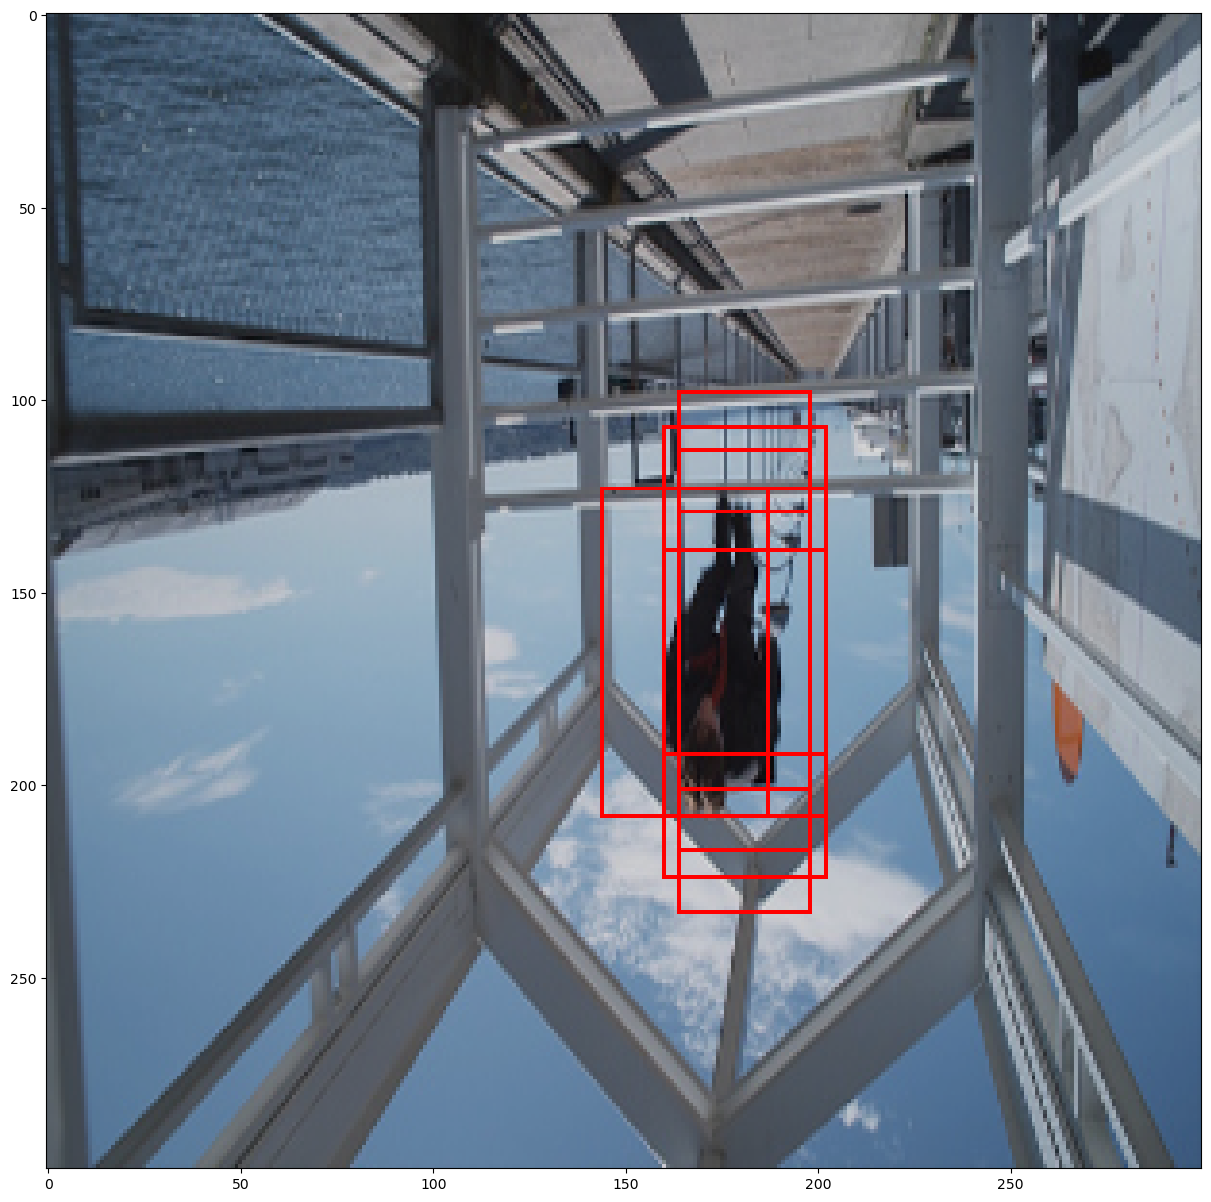

In [11]:
image = hold[image_number][:]

plt.figure(figsize=(15, 15))

for i, turf in enumerate(holdout[1][0][image_number]):
    
    _, _, _, _, xfactor = turf.numpy()
    
    if xfactor == 1.0:
        start_x, start_y, end_x, end_y = boxes[i].numpy() * 300
        
        print(start_x, start_y, end_x, end_y)
        start_x, start_y, end_x, end_y = int(start_x), int(start_y), int(end_x), int(end_y)

        cv2.rectangle(image, [start_x, start_y], [end_x, end_y], color=(255,0,0), thickness = 1)

plt.imshow(image)

In [12]:
loss = SSDLoss(negative_mining_ratio = 2)

In [13]:
i = 0
for d in dg:
    holdout = d
    pred = VGG_16.predict(holdout[0])
    loc_los = loss.localization_loss(holdout[1][0], pred[0])
    conf_loss = loss.confidence_loss(holdout[1][1], pred[1])
    print(tf.reduce_sum(holdout[1][1][:, :, 1:], axis = 1))
#     print( 'loc_los: ', tf.reduce_sum(loc_los, axis = 1) )
#     print( 'conf_loss: ', tf.reduce_sum(conf_loss, axis = 1) )
    print( 'loc_los: ', loc_los )
    print( 'conf_loss: ', conf_loss )
    print('-'*30)
    i+=1
    if i > 3:
        break

2022-09-14 22:21:33.345146: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-09-14 22:21:33.595426: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


1/1 [==============================] - 3s 3s/step
tf.Tensor(
[[ 6.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [12.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 14.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [12.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [26.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 6

1/1 [==============================] - 0s 40ms/step
tf.Tensor(
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 42.
   0.  0.]
 [12.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 29.  0.  0.  0.  0.
   0.  0.]
 [ 4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [15.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [13.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  5.  0.  0.
   0.  0.]
 [ 0.  0.  6.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [19.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.
   0. 15.]
 [ 6.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [54.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0. 19.]
 [

In [14]:
def scheduler(epoch, lr):
    if epoch < 250:
        return 1e-4
    elif epoch < 480:
        return 5e-5
    else:
        return lr * tf.math.exp(-0.1)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [15]:
VGG_16.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1 = 0.9, epsilon=0.01), loss=[loss.localization_loss, loss.confidence_loss])

In [16]:
history = VGG_16.fit(dg, callbacks=[callback], epochs = 500)

Epoch 1/500
156/156 [==============================] - 167s 1s/step - loss: 193.6683 - mbox_loc_loss: 62.4367 - mbox_conf_softmax_loss: 125.2561 - lr: 1.0000e-04
Epoch 2/500
156/156 [==============================] - 162s 1s/step - loss: 188.5720 - mbox_loc_loss: 61.4861 - mbox_conf_softmax_loss: 121.1161 - lr: 1.0000e-04
Epoch 3/500
156/156 [==============================] - 162s 1s/step - loss: 186.0123 - mbox_loc_loss: 60.6525 - mbox_conf_softmax_loss: 119.3945 - lr: 1.0000e-04
Epoch 4/500
156/156 [==============================] - 161s 1s/step - loss: 183.9651 - mbox_loc_loss: 59.7520 - mbox_conf_softmax_loss: 118.2514 - lr: 1.0000e-04
Epoch 5/500
156/156 [==============================] - 161s 1s/step - loss: 181.2611 - mbox_loc_loss: 59.1230 - mbox_conf_softmax_loss: 116.1792 - lr: 1.0000e-04
Epoch 6/500
156/156 [==============================] - 162s 1s/step - loss: 180.4434 - mbox_loc_loss: 58.4770 - mbox_conf_softmax_loss: 116.0098 - lr: 1.0000e-04
Epoch 7/500
156/156 [=======

156/156 [==============================] - 161s 1s/step - loss: 144.5566 - mbox_loc_loss: 44.9821 - mbox_conf_softmax_loss: 93.5861 - lr: 1.0000e-04
Epoch 52/500
156/156 [==============================] - 160s 1s/step - loss: 144.0208 - mbox_loc_loss: 44.6564 - mbox_conf_softmax_loss: 93.3742 - lr: 1.0000e-04
Epoch 53/500
156/156 [==============================] - 161s 1s/step - loss: 144.1779 - mbox_loc_loss: 44.5847 - mbox_conf_softmax_loss: 93.6010 - lr: 1.0000e-04
Epoch 54/500
156/156 [==============================] - 160s 1s/step - loss: 143.5286 - mbox_loc_loss: 44.3685 - mbox_conf_softmax_loss: 93.1660 - lr: 1.0000e-04
Epoch 55/500
156/156 [==============================] - 159s 1s/step - loss: 142.0261 - mbox_loc_loss: 44.2042 - mbox_conf_softmax_loss: 91.8256 - lr: 1.0000e-04
Epoch 56/500
156/156 [==============================] - 159s 1s/step - loss: 143.2215 - mbox_loc_loss: 44.2552 - mbox_conf_softmax_loss: 92.9685 - lr: 1.0000e-04
Epoch 57/500
156/156 [===================

156/156 [==============================] - 160s 1s/step - loss: 128.7847 - mbox_loc_loss: 38.6677 - mbox_conf_softmax_loss: 84.0170 - lr: 1.0000e-04
Epoch 102/500
156/156 [==============================] - 161s 1s/step - loss: 129.4072 - mbox_loc_loss: 39.5139 - mbox_conf_softmax_loss: 83.7906 - lr: 1.0000e-04
Epoch 103/500
156/156 [==============================] - 159s 1s/step - loss: 128.0203 - mbox_loc_loss: 38.7045 - mbox_conf_softmax_loss: 83.2105 - lr: 1.0000e-04
Epoch 104/500
156/156 [==============================] - 159s 1s/step - loss: 129.6078 - mbox_loc_loss: 39.1055 - mbox_conf_softmax_loss: 84.3945 - lr: 1.0000e-04
Epoch 105/500
156/156 [==============================] - 160s 1s/step - loss: 126.6692 - mbox_loc_loss: 38.0799 - mbox_conf_softmax_loss: 82.4790 - lr: 1.0000e-04
Epoch 106/500
156/156 [==============================] - 160s 1s/step - loss: 128.1002 - mbox_loc_loss: 38.7484 - mbox_conf_softmax_loss: 83.2390 - lr: 1.0000e-04
Epoch 107/500
156/156 [=============

156/156 [==============================] - 159s 1s/step - loss: 120.2826 - mbox_loc_loss: 35.6718 - mbox_conf_softmax_loss: 78.3802 - lr: 1.0000e-04
Epoch 152/500
156/156 [==============================] - 159s 1s/step - loss: 117.8477 - mbox_loc_loss: 35.2045 - mbox_conf_softmax_loss: 76.4099 - lr: 1.0000e-04
Epoch 153/500
156/156 [==============================] - 160s 1s/step - loss: 120.1302 - mbox_loc_loss: 35.6492 - mbox_conf_softmax_loss: 78.2450 - lr: 1.0000e-04
Epoch 154/500
156/156 [==============================] - 160s 1s/step - loss: 117.7671 - mbox_loc_loss: 34.6882 - mbox_conf_softmax_loss: 76.8402 - lr: 1.0000e-04
Epoch 155/500
156/156 [==============================] - 158s 1s/step - loss: 118.4625 - mbox_loc_loss: 35.0694 - mbox_conf_softmax_loss: 77.1517 - lr: 1.0000e-04
Epoch 156/500
156/156 [==============================] - 159s 1s/step - loss: 117.6707 - mbox_loc_loss: 34.7834 - mbox_conf_softmax_loss: 76.6434 - lr: 1.0000e-04
Epoch 157/500
156/156 [=============

156/156 [==============================] - 159s 1s/step - loss: 113.6586 - mbox_loc_loss: 33.6160 - mbox_conf_softmax_loss: 73.6754 - lr: 1.0000e-04
Epoch 202/500
156/156 [==============================] - 158s 1s/step - loss: 113.1658 - mbox_loc_loss: 33.6004 - mbox_conf_softmax_loss: 73.1958 - lr: 1.0000e-04
Epoch 203/500
156/156 [==============================] - 158s 1s/step - loss: 114.8269 - mbox_loc_loss: 33.7882 - mbox_conf_softmax_loss: 74.6668 - lr: 1.0000e-04
Epoch 204/500
156/156 [==============================] - 158s 1s/step - loss: 111.1363 - mbox_loc_loss: 32.4557 - mbox_conf_softmax_loss: 72.3058 - lr: 1.0000e-04
Epoch 205/500
156/156 [==============================] - 158s 1s/step - loss: 111.5331 - mbox_loc_loss: 32.5594 - mbox_conf_softmax_loss: 72.5959 - lr: 1.0000e-04
Epoch 206/500
156/156 [==============================] - 159s 1s/step - loss: 113.1037 - mbox_loc_loss: 33.3717 - mbox_conf_softmax_loss: 73.3515 - lr: 1.0000e-04
Epoch 207/500
156/156 [=============

156/156 [==============================] - 159s 1s/step - loss: 162.7943 - mbox_loc_loss: 50.8641 - mbox_conf_softmax_loss: 105.3434 - lr: 5.0000e-04
Epoch 252/500
156/156 [==============================] - 156s 1s/step - loss: 170.1814 - mbox_loc_loss: 53.7223 - mbox_conf_softmax_loss: 109.7304 - lr: 5.0000e-04
Epoch 253/500
156/156 [==============================] - 158s 1s/step - loss: 167.7674 - mbox_loc_loss: 53.2327 - mbox_conf_softmax_loss: 107.6979 - lr: 5.0000e-04
Epoch 254/500
156/156 [==============================] - 158s 1s/step - loss: 163.9207 - mbox_loc_loss: 52.1539 - mbox_conf_softmax_loss: 104.8342 - lr: 5.0000e-04
Epoch 255/500
156/156 [==============================] - 159s 1s/step - loss: 162.6721 - mbox_loc_loss: 51.7261 - mbox_conf_softmax_loss: 103.9200 - lr: 5.0000e-04
Epoch 256/500
156/156 [==============================] - 158s 1s/step - loss: 161.8665 - mbox_loc_loss: 51.1789 - mbox_conf_softmax_loss: 103.5749 - lr: 5.0000e-04
Epoch 257/500
156/156 [=======

156/156 [==============================] - 159s 1s/step - loss: 138.8503 - mbox_loc_loss: 41.8568 - mbox_conf_softmax_loss: 86.6676 - lr: 5.0000e-04
Epoch 302/500
156/156 [==============================] - 158s 1s/step - loss: 138.2601 - mbox_loc_loss: 41.4498 - mbox_conf_softmax_loss: 86.4242 - lr: 5.0000e-04
Epoch 303/500
156/156 [==============================] - 158s 1s/step - loss: 135.7169 - mbox_loc_loss: 40.6428 - mbox_conf_softmax_loss: 84.6247 - lr: 5.0000e-04
Epoch 304/500
156/156 [==============================] - 159s 1s/step - loss: 134.9567 - mbox_loc_loss: 40.7936 - mbox_conf_softmax_loss: 83.6486 - lr: 5.0000e-04
Epoch 305/500
156/156 [==============================] - 159s 1s/step - loss: 136.8190 - mbox_loc_loss: 41.6031 - mbox_conf_softmax_loss: 84.6356 - lr: 5.0000e-04
Epoch 306/500
156/156 [==============================] - 159s 1s/step - loss: 136.7460 - mbox_loc_loss: 41.2538 - mbox_conf_softmax_loss: 84.8474 - lr: 5.0000e-04
Epoch 307/500
156/156 [=============

156/156 [==============================] - 159s 1s/step - loss: 128.2312 - mbox_loc_loss: 37.1165 - mbox_conf_softmax_loss: 77.9561 - lr: 5.0000e-04
Epoch 352/500
156/156 [==============================] - 157s 1s/step - loss: 129.4029 - mbox_loc_loss: 37.8247 - mbox_conf_softmax_loss: 78.3689 - lr: 5.0000e-04
Epoch 353/500
156/156 [==============================] - 158s 1s/step - loss: 128.4059 - mbox_loc_loss: 37.5770 - mbox_conf_softmax_loss: 77.5725 - lr: 5.0000e-04
Epoch 354/500
156/156 [==============================] - 158s 1s/step - loss: 126.8440 - mbox_loc_loss: 36.7398 - mbox_conf_softmax_loss: 76.8012 - lr: 5.0000e-04
Epoch 355/500
156/156 [==============================] - 159s 1s/step - loss: 128.8053 - mbox_loc_loss: 37.6261 - mbox_conf_softmax_loss: 77.8280 - lr: 5.0000e-04
Epoch 356/500
156/156 [==============================] - 158s 1s/step - loss: 127.7823 - mbox_loc_loss: 36.9410 - mbox_conf_softmax_loss: 77.4420 - lr: 5.0000e-04
Epoch 357/500
156/156 [=============

156/156 [==============================] - 159s 1s/step - loss: 123.4559 - mbox_loc_loss: 34.9127 - mbox_conf_softmax_loss: 73.2357 - lr: 5.0000e-04
Epoch 402/500
156/156 [==============================] - 157s 1s/step - loss: 122.4400 - mbox_loc_loss: 34.6194 - mbox_conf_softmax_loss: 72.4722 - lr: 5.0000e-04
Epoch 403/500
156/156 [==============================] - 161s 1s/step - loss: 122.5999 - mbox_loc_loss: 34.6994 - mbox_conf_softmax_loss: 72.5137 - lr: 5.0000e-04
Epoch 404/500
156/156 [==============================] - 159s 1s/step - loss: 120.5344 - mbox_loc_loss: 33.8248 - mbox_conf_softmax_loss: 71.2875 - lr: 5.0000e-04
Epoch 405/500
156/156 [==============================] - 157s 1s/step - loss: 121.1383 - mbox_loc_loss: 33.5609 - mbox_conf_softmax_loss: 72.1234 - lr: 5.0000e-04
Epoch 406/500
156/156 [==============================] - 160s 1s/step - loss: 120.2427 - mbox_loc_loss: 33.5579 - mbox_conf_softmax_loss: 71.1975 - lr: 5.0000e-04
Epoch 407/500
156/156 [=============

156/156 [==============================] - 160s 1s/step - loss: 118.6810 - mbox_loc_loss: 33.0377 - mbox_conf_softmax_loss: 68.7185 - lr: 5.0000e-04
Epoch 452/500
156/156 [==============================] - 159s 1s/step - loss: 118.3655 - mbox_loc_loss: 32.8739 - mbox_conf_softmax_loss: 68.5335 - lr: 5.0000e-04
Epoch 453/500
156/156 [==============================] - 158s 1s/step - loss: 118.0864 - mbox_loc_loss: 32.5899 - mbox_conf_softmax_loss: 68.5102 - lr: 5.0000e-04
Epoch 454/500
156/156 [==============================] - 159s 1s/step - loss: 119.8838 - mbox_loc_loss: 33.4861 - mbox_conf_softmax_loss: 69.3829 - lr: 5.0000e-04
Epoch 455/500
156/156 [==============================] - 159s 1s/step - loss: 118.8633 - mbox_loc_loss: 32.8670 - mbox_conf_softmax_loss: 68.9511 - lr: 5.0000e-04
Epoch 456/500
156/156 [==============================] - 160s 1s/step - loss: 120.0383 - mbox_loc_loss: 33.3543 - mbox_conf_softmax_loss: 69.6056 - lr: 5.0000e-04
Epoch 457/500
156/156 [=============

dict_keys(['loss', 'mbox_loc_loss', 'mbox_conf_softmax_loss', 'lr'])


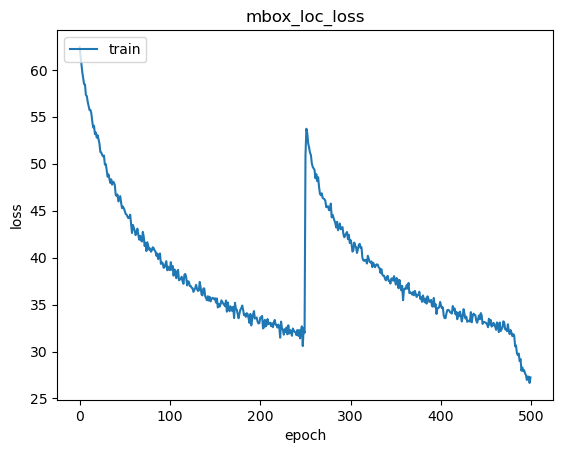

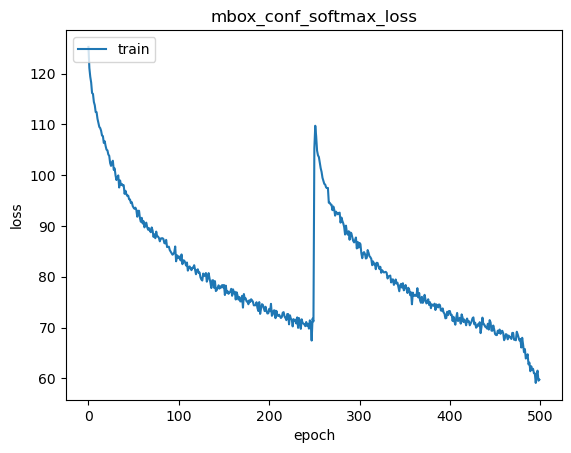

In [17]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mbox_loc_loss'])
# plt.plot(history.history['val_mbox_loc_loss'])
plt.title('mbox_loc_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['mbox_conf_softmax_loss'])
# plt.plot(history.history['val_mbox_conf_softmax_loss'])
plt.title('mbox_conf_softmax_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [69]:
# VGG_16.save_weights('checkpoints/SSD_VOC_5000_images_500_iters')

In [19]:
test = DataGenerator(list_IDs, 
                   label_path,
                   image_path, 
                   prior_boxes,
                   boxes,
                  batch_size=32,
                   n_classes = 20,
                  image_extension='.jpg',
                  training = False)

In [20]:
for d in test:
    holdout = d
    break

In [107]:
images = []

image = cv2.imread('/home/usman/Downloads/RS8220_Doune-Porter_bn_h2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (300, 300))

images.append(image)

In [108]:
images = np.array(images) / 255.

In [109]:
images.shape

(1, 300, 300, 3)

In [110]:
pred = VGG_16.predict(images)

1/1 [==============================] - 0s 23ms/step


In [111]:
# pred = VGG_16.predict(holdout[0])


In [112]:
pred[0].shape

(1, 8732, 4)

In [113]:
conf_loss = pred[1]

In [114]:
image_number = 0
conf_loss_max = []

for i, conf in enumerate(conf_loss[image_number]):
#     print(conf)
    conf_loss_max.append([np.max(conf[1:]), np.argmax(conf[1:]), i])
    
conf_loss_max.sort(reverse=True)

In [115]:
conf_loss_max[:10]

[[0.4660657, 0, 8711],
 [0.25366935, 0, 8619],
 [0.24139921, 0, 8618],
 [0.19719365, 0, 8649],
 [0.18804109, 0, 8650],
 [0.18256238, 0, 8277],
 [0.17309007, 0, 8720],
 [0.1697982, 0, 8723],
 [0.16730264, 0, 8654],
 [0.16334076, 0, 8614]]

In [116]:
g_cx_pred = pred[0][:,:,0] * prior_boxes[:,2] / 10 + prior_boxes[:,0]

g_cy_pred =  pred[0][:,:,1] * prior_boxes[:,3] / 10 + prior_boxes[:,1]

g_w_pred = tf.exp(pred[0][:,:,2] / 5) * prior_boxes[:,2]

g_h_pred = tf.exp(pred[0][:,:,3] / 5) * prior_boxes[:,3]

g_x_min = g_cx_pred - g_w_pred / 2
g_y_min = g_cy_pred - g_h_pred / 2

g_x_max = g_cx_pred + g_w_pred / 2
g_y_max = g_cy_pred + g_h_pred / 2

# tf.transpose(g_x_min, perm=(0,1))

g_x_min_t = tf.transpose(tf.expand_dims(g_x_min, axis = 0), perm=(1,2,0))
g_y_min_t = tf.transpose(tf.expand_dims(g_y_min, axis = 0), perm=(1,2,0))

g_x_max_t = tf.transpose(tf.expand_dims(g_x_max, axis = 0), perm=(1,2,0))
g_y_max_t = tf.transpose(tf.expand_dims(g_y_max, axis = 0), perm=(1,2,0))

g_pred = tf.concat([g_x_min_t, g_y_min_t, g_x_max_t, g_y_max_t], axis = 2)

In [123]:
selected_indices = tf.image.non_max_suppression(
                g_pred[image_number], 
                tf.reduce_max(conf_loss[image_number][:,1:], axis = 1), 
                max_output_size=50,
                iou_threshold=0.5,
                score_threshold=0.4)

selected_boxes = tf.gather(g_pred[image_number], selected_indices)
labels_for_boxes = tf.argmax(tf.gather(conf_loss[image_number], selected_indices),axis = 1)

In [124]:
labels_for_boxes.shape

TensorShape([1])

In [125]:
VOC_labels = '''person,bird,cat,cow,dog,horse,sheep,aeroplane,bicycle,boat,bus,car,motorbike,train,bottle,chair,diningtable,pottedplant,sofa,tvmonitor'''

VOC_labels = VOC_labels.split(',')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


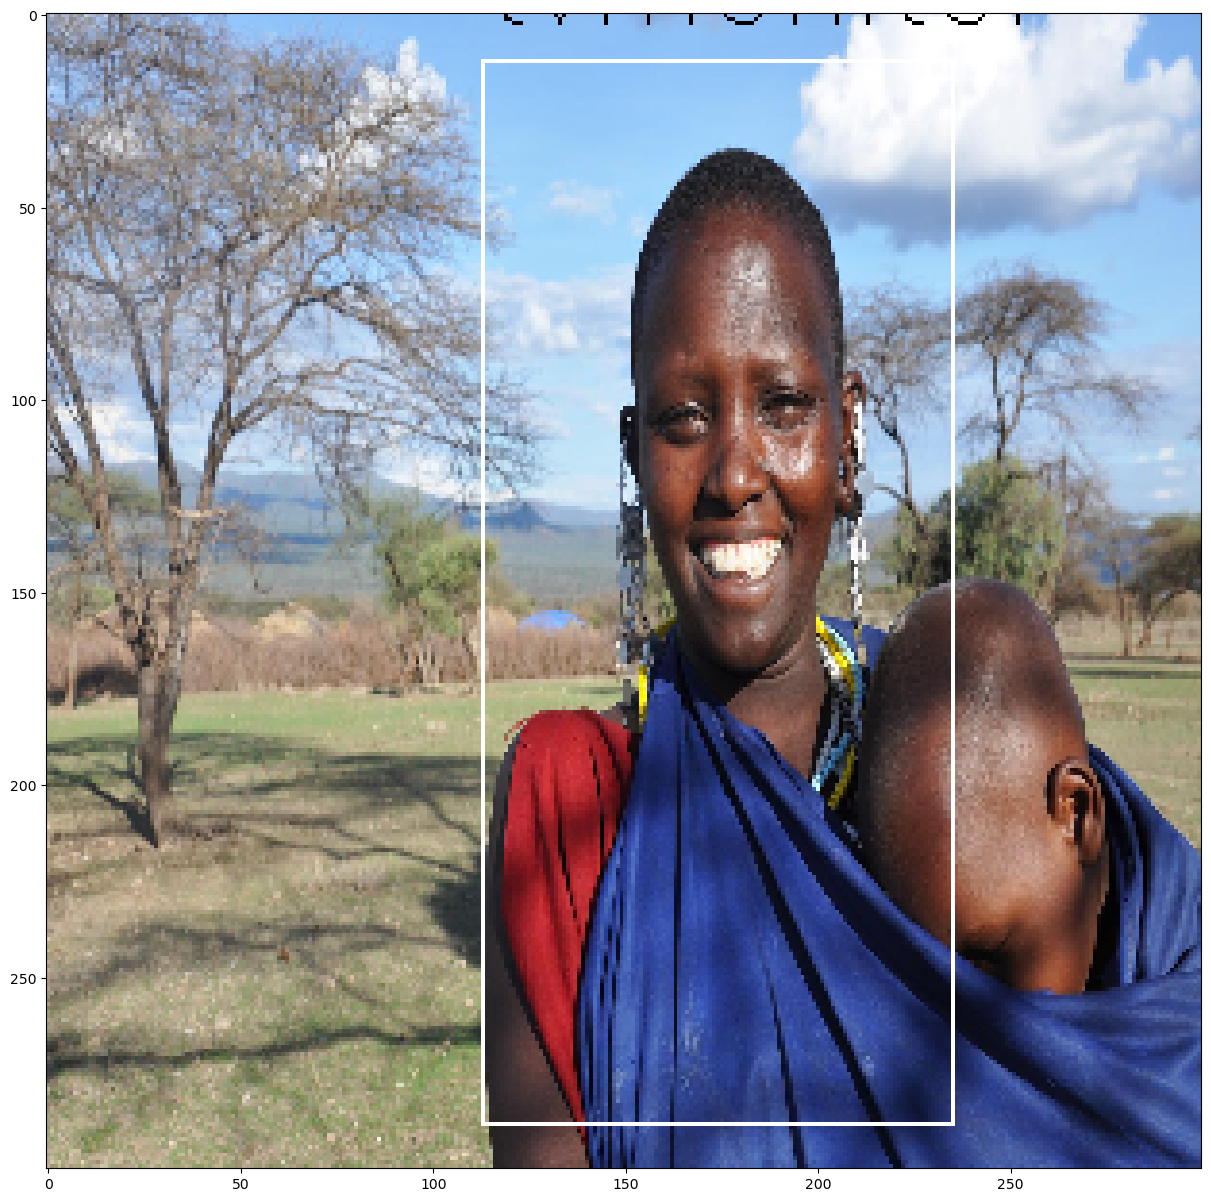

In [126]:
# image = holdout[0][image_number][:]
image = images[0]

for i in range(selected_boxes.shape[0]):
    
    start_x, start_y, end_x, end_y = selected_boxes[i].numpy() * 300

#     start_x, start_y, end_x, end_y = g_x_min[image_number][i].numpy() * 300, g_y_min[image_number][i].numpy() * 300, g_x_max[image_number][i].numpy() * 300, g_y_max[image_number][i].numpy() * 300

    start_x, start_y, end_x, end_y = int(start_x), int(start_y), int(end_x), int(end_y)

    cv2.rectangle(image, [start_x, start_y], [end_x, end_y], color=(255,10,10), thickness = 1)
    
    label_idx = labels_for_boxes[i].numpy()
    
    cv2.putText(image, text= str(VOC_labels[label_idx - 1]), org=(start_x, start_y-10),
            fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0),
            thickness=1, lineType=cv2.LINE_AA)

plt.figure(figsize=(15, 15))


plt.imshow(image)